# 量子機械学習によるデフォルト予測

## セットアップ

In [100]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

#その他の設定


## 1. データの読み込み

In [122]:
main_path="C:/Users/finst/OneDrive/デスクトップ/wataru/13_仕事/量子機械学習/home-credit-default-risk"
path_all_data=main_path+"/application.csv" #特徴量データのパス
path_testID=main_path+"/test_key.csv" #テストデータのID
path_trainID=main_path+"/train_key.csv" #訓練データのID

### 1.1 生データを読み込む

全てのデータを読み込む

In [150]:
all_data = pd.read_csv(path_all_data)
trainID = pd.read_csv(path_trainID)
#IDがかぶっているもののみ抽出
ID_overwrap = list(set(all_data.SK_ID_CURR) & set(trainID.SK_ID_CURR))
all_data = all_data[all_data.SK_ID_CURR.isin(ID_overwrap)]
trainID = trainID[trainID.SK_ID_CURR.isin(ID_overwrap)]

#データサイズを確認
all_data.shape

(307358, 121)

### 1.2 データの前処理

In [151]:
# onehotにする列を指定
list_onehot = ["NAME_TYPE_SUITE","NAME_INCOME_TYPE","NAME_HOUSING_TYPE","NAME_EDUCATION_TYPE",
               "NAME_FAMILY_STATUS","OCCUPATION_TYPE",
               "WEEKDAY_APPR_PROCESS_START","ORGANIZATION_TYPE"]
#01に置き換える列を指定
list_01 = ["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY"]

#量的変数
merge =list_onehot+list_01
list_quantity = list(set(all_data.columns)-set(merge))


In [152]:
#変数を減らすために実行
all_data = all_data[["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]]
list_quantity=["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]
for col in ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]:
    all_data[col]=all_data[col].fillna(all_data[col].mean())
    all_data[col]=(all_data[col]-all_data[col].mean())/all_data[col].std()

In [153]:
#外れ値の処理
def outlier_2s(df):

    for i in range(len(df.columns)-1):

        # 列を抽出する
        col = df.iloc[:,i]

        # 平均と標準偏差
        average = np.mean(col)
        sd = np.std(col)

        # 外れ値の基準点
        outlier_min = average - (sd) * 2
        outlier_max = average + (sd) * 2

        # 範囲から外れている値を除く
        col_name = df.columns[i]
        df[df[col_name]<outlier_min]=None
        df[df[col_name]>outlier_max]=None

        
    df = df.dropna(how='any', axis=0)

    return df

TARGET = trainID["TARGET"].tolist()
all_data["TARGET"]=TARGET
all_data = outlier_2s(all_data)

#### 【データへの変換】

In [154]:
#-1～1の範囲に限定する
for col in ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]:
    all_data[col]=all_data[col]/max(all_data[col].abs())

#### 【テストデータと訓練データの分割し，アンダーサンプリング】

In [155]:
X_train, X_test, y_train, y_test = train_test_split(all_data[["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]], all_data.TARGET, test_size=0.3, random_state=0)
#1の数が圧倒的少ないので，割合を調整

from imblearn.under_sampling import RandomUnderSampler
# クラス1の数を保存
count_train_class_one = int(y_train.sum())
# クラス1が全体の10％になるまでクラス0を減らす
under = RandomUnderSampler(sampling_strategy={0:count_train_class_one, 1:count_train_class_one}, random_state=100)

# 学習用データに反映
X_train, y_train = under.fit_resample(X_train, y_train)

#古典NNのためにデータを保存
X_train_c, X_test_c, y_train_c, y_test_c=X_train, X_test, y_train, y_test

#### 【量子回路への変換】

In [156]:
def convert_to_circuit(credit_info):
    qubits = cirq.GridQubit.rect(len(credit_info), 1)
    circuit = cirq.Circuit()
    for i, value in enumerate(credit_info):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

X_train = X_train.values.tolist()
X_test = X_test.values.tolist()

In [157]:
x_train_circ = [convert_to_circuit(x) for x in X_train]
x_test_circ = [convert_to_circuit(x) for x in X_test]

In [158]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. 量子ニューラルネットワーク

画像を分類する量子回路構造に関するガイダンスはほとんどありません。分類は読み出されるキュービットの期待に基づいて行われるため、<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> は、2 つのキュービットゲートを使用して、読み出しキュービットが必ず作用されるようにすることを提案しています。これはある意味、ピクセル全体に小さな<a href="https://arxiv.org/abs/1511.06464" class="external">ユニタリ RNN</a>を実行することに似ています。

### 2.1 モデル回路を構築する

次の例では、このレイヤー化アプローチを説明しています。各レイヤーは同一ゲートの *n* 個のインスタンスを使用しており、各データキュービットは読み出しキュービットに影響を与えています。

ゲートのレイヤーを回路に追加する簡単なクラスから始めましょう。

In [159]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

では、2 レイヤーモデルを構築しましょう。 データ回路サイズに一致するようにし、準備と読み出し演算を含めます。

In [160]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(len(X_train[0]), 1)  
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [161]:
model_circuit, model_readout = create_quantum_model()

### 2.2 tfq-keras モデルでモデル回路をラップする

量子コンポーネントで Keras モデルを構築します。このモデルには、古典的なデータをエンコードする「量子データ」が `x_train_circ` からフィードされます。*パラメータ化された量子回路*レイヤーの `tfq.layers.PQC` を使用して、量子データでモデル回路をトレーニングするモデルです。

<a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> は、画像を分類するには、パラメータ化された回路で読み出しキュービットの期待値を使用することを提案しています。期待値は、1 から -1 の値です。

In [162]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

次に、`compile` メソッドを使用して、モデルにトレーニング手順を指定します。

期待される読み出しは `[-1,1]` の範囲であるため、ヒンジ損失を最適化すると、ある程度自然な適合となります。

注意: もう 1 つの有効なアプローチとして、出力範囲を `[0,1]` にシフトし、モデルがクラス `3` に割りてる確率として扱う方法があります。これは、標準的な`tf.losses.BinaryCrossentropy` 損失で使用することができます。

ここでヒンジ損失を使用するには、小さな調整を 2 つ行う必要があります。まず、ラベル `y_train_nocon` をブール型からヒンジ損失が期待する `[-1,1]` に変換することです。

In [163]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

次に、`[-1, 1]` を `y_true` ラベル引数として正しく処理するカスタムの `hinge_accuracy` メトリックを使用します。`tf.losses.BinaryAccuracy(threshold=0.0)` は `y_true` がブール型であることを期待するため、ヒンジ損失とは使用できません。

In [164]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [165]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [166]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_3 (PQC)                  (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
None


### 量子モデルをトレーニングする

では、モデルをトレーニングしましょう。これには約 45 分かかりますが、その時間を待てない方は、小規模なデータのサブセット（以下の`NUM_EXAMPLES=500` セット）を使用するとよいでしょう。トレーニング時のモデルの進捗にあまり影響はありません（パラメータは 32 しかなく、これらを制約する上であまりデータは必要ありません）。サンプル数を減らすことでトレーニングを早めに（5 分程度）終わらせることができますが、検証ログに進捗状況を示すには十分な長さです。

In [167]:
EPOCHS = 3
BATCH_SIZE = 128

このモデルを収束までトレーニングすると、テストセットにおいて 85% を超える精度が達成されます。

In [168]:
qnn_history = model.fit(
      x_train_tfcirc, y_train_hinge,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Train on 23328 samples, validate on 75666 samples
Epoch 1/3
23328/23328 [==============================] - 7s 320us/sample - loss: 1.0001 - hinge_accuracy: 0.5000 - val_loss: 0.8258 - val_hinge_accuracy: 0.9344
Epoch 2/3
23328/23328 [==============================] - 7s 306us/sample - loss: 1.0001 - hinge_accuracy: 0.4996 - val_loss: 0.8183 - val_hinge_accuracy: 0.9344
Epoch 3/3
75666/75666 [==============================] - 4s 55us/sample - loss: 0.8333 - hinge_accuracy: 0.9344


In [169]:
model.predict(x_test_tfcirc)

array([[-0.19192085],
       [-0.19192085],
       [-0.19192085],
       ...,
       [-0.19192085],
       [-0.19192085],
       [-0.19192085]], dtype=float32)

注意: トレーニング精度はエポックの平均値を示します。検証精度はエポックの終了ごとに評価されます。

## 3. 従来のニューラルネットワーク

量子ニューラルネットワークは、この単純化された MNIST 問題で機能するものの、このタスクでは、従来のニューラルネットワークの性能が QNN をはるかに上回ります。1 つのエポックが終了した時点で、従来のニューラルネットワークは縮小したセットで 98% を超える精度を達成することができます。

次の例では、画像をサブサンプリングする代わりに 28x28 の画像を使用した 3 と 6 の分類問題に従来のニューラルネットワークを使用しています。これはほぼ 100% 精度のテストセットに難なく収束します。

In [143]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    #model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    #model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    #model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    #model.add(tf.keras.layers.Dropout(0.25))
    #model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10, activation='relu',input_shape = (3,)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(5, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                40        
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [144]:
model.fit(X_train_c,
          y_train_c,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(X_test_c, y_test_c))

cnn_results = model.evaluate(X_test_c, y_test_c)

Train on 23328 samples, validate on 75666 samples
75666/75666 [==============================] - 1s 10us/sample - loss: 0.6615 - accuracy: 0.9332


In [146]:
model.predict(X_test)

array([[-0.1150108 ],
       [ 0.22811824],
       [-0.43930542],
       ...,
       [-0.36513916],
       [-0.1921977 ],
       [ 0.25203726]], dtype=float32)

## 4. 比較

解像度の高い入力とより強力なモデルの場合、CNN はこの問題を簡単に解決できますが、似たようなパワー（最大 32 個のパラメータ）を持つ古典的モデルはわずかな時間で似たような精度までトレーニングすることができます。いずれにせよ、従来のニューラルネットワークは量子ニューラルネットワークの性能を簡単に上回ります。古典的なデータでは、従来のニューラルネットワークを上回るのは困難といえます。

C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

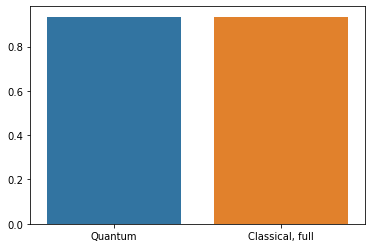

In [145]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]


sns.barplot(["Quantum", "Classical, full"],
            [qnn_accuracy, cnn_accuracy ])